In [37]:
import pandas as pd

# Load the voter file
df = pd.read_csv('voterfile.csv')

In [38]:
print(df.columns)

Index(['optimus_id', 'age', 'party', 'ethnicity', 'maritalstatus',
       'dwellingtype', 'income', 'education', 'cd', 'dma',
       'occupationindustry', 'vh14p', 'vh12g', 'vh12p', 'vh10g', 'vh10p',
       'vh08g', 'vh08p', 'vh06g', 'vh06p', 'vh04g', 'vh04p', 'vh02g', 'vh02p',
       'vh00g', 'vh00p', 'net_worth', 'petowner_dog', 'intrst_nascar_in_hh',
       'intrst_musical_instruments_in_hh', 'donates_to_liberal_causes',
       'donates_to_conservative_causes', 'home_owner_or_renter',
       'g08_precinct_turnout', 'g10_precinct_turnout', 'g12_precinct_turnout',
       'p08_precinct_turnout', 'p10_precinct_turnout', 'p12_precinct_turnout'],
      dtype='object')


In [39]:
df.shape

(50000, 39)

In [40]:
df.dtypes

optimus_id                            int64
age                                 float64
party                                object
ethnicity                            object
maritalstatus                        object
dwellingtype                         object
income                               object
education                            object
cd                                  float64
dma                                  object
occupationindustry                   object
vh14p                                 int64
vh12g                                 int64
vh12p                                 int64
vh10g                                 int64
vh10p                                 int64
vh08g                                 int64
vh08p                                 int64
vh06g                                 int64
vh06p                                 int64
vh04g                                 int64
vh04p                                 int64
vh02g                           

In [41]:
df['age'].isnull().sum()

17

In [42]:
df['net_worth'].isnull().sum()

25948

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel

# Drop irrelevant columns
irr_cols = ['income', 'dma', 'occupationindustry', 'petowner_dog', 'intrst_nascar_in_hh',
            'intrst_musical_instruments_in_hh', 'home_owner_or_renter']
df.drop(columns=irr_cols, inplace=True)

# Handle net worth column
df['net_worth'] = df['net_worth'].str.replace('[\$,]', '', regex=True)
df['net_worth'] = df['net_worth'].str.replace('\+', '', regex=True)
df['net_worth'] = df['net_worth'].str.split('-').apply(lambda x: sum(map(float, x)) / len(x)
                                                        if isinstance(x, list) else float(x))

# Encode categorical variables using one-hot encoding
categorical_columns = ['party', 'ethnicity', 'maritalstatus', 'dwellingtype', 'education',
                       'donates_to_liberal_causes', 'donates_to_conservative_causes']
for col in categorical_columns:
    one_hot_encoded = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, one_hot_encoded], axis=1)
df.drop(columns=categorical_columns, inplace=True)

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Scale numerical features
scaler = StandardScaler()
numerical_columns = ['age', 'net_worth']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Define features and target
X = df.drop(columns=['vh14p', 'optimus_id'])
y = df['vh14p']


In [44]:
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model with L1 regularization for feature selection
log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
log_reg_l1.fit(X_train, y_train)

# Perform feature selection based on non-zero coefficients
selected_features = X.columns[log_reg_l1.coef_[0] != 0]

# Print relevant features and their coefficients
print("Relevant Features and their Coefficients:")
coefficients = log_reg_l1.coef_[0]
for feature, coefficient in zip(X.columns, coefficients):
    print(f"{feature}: {coefficient}")

# Print top 5 relevant features
print("\nTop 5 Relevant Features:")
top5_relevant_features = selected_features[:5]
for feature in top5_relevant_features:
    print(feature)

# Subset the data with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Retrain the model on selected features
log_reg_l1.fit(X_train_selected, y_train)

# Make predictions on the test set with selected features
y_pred_selected = log_reg_l1.predict(X_test_selected)

# Evaluate the model with selected features
accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f'\nModel accuracy with selected features: {accuracy_selected:.3f}')

# Print classification report for additional evaluation metrics
print(classification_report(y_test, y_pred_selected))

# Make predictions on the entire dataset with selected features
df['vote_prob'] = log_reg_l1.predict_proba(X[selected_features])[:, 1]
df['vote'] = (df['vote_prob'] > 0.5).astype(int)

# Save the selected features to a CSV file
selected_features_df = df[['optimus_id'] + selected_features.tolist()]
selected_features_df.to_csv('selected_features.csv', index=False)

# Save the predictions to a CSV file
df[['optimus_id', 'vote', 'vote_prob']].to_csv('predictions.csv', index=False)


Relevant Features and their Coefficients:
age: 0.31654736989142135
cd: -0.038772105950670765
vh12g: 1.5916353116547863
vh12p: 1.1150325838398412
vh10g: 0.9853015582162142
vh10p: 0.7244479390529093
vh08g: 0.029139710672808142
vh08p: 0.3107485100257868
vh06g: 0.13051373080764334
vh06p: 0.35639214928269564
vh04g: 0.3282030832656761
vh04p: 0.1547652015496843
vh02g: 0.0
vh02p: 0.19539837183361772
vh00g: 0.09981594275817687
vh00p: 0.0902657310048833
net_worth: -0.020974972837854187
g08_precinct_turnout: 1.3183438732741635
g10_precinct_turnout: -0.0001613167292619249
g12_precinct_turnout: -1.003909707546099
p08_precinct_turnout: 0.0
p10_precinct_turnout: -0.11791777033279398
p12_precinct_turnout: -0.13694670433082728
party_American Independent: -0.2952581985489794
party_Democratic: 0.0
party_Green: 0.8885030966359844
party_Libertarian: 0.0
party_Natural Law: 0.0
party_Non-Partisan: -0.2009354123802401
party_Other: 0.0
party_Republican: 0.05073373583202808
ethnicity_African-American: 0.7967326

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

# Sort features based on their importances
sorted_features_rf = sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True)

# Print relevant features and their importances
print("Relevant Features and their Importances (Random Forest):")
for feature, importance in sorted_features_rf:
    print(f"{feature}: {importance}")

# Use selected features for predictions
selected_features_rf = [feature for feature, _ in sorted_features_rf[:10]]  # Select top 10 features, for example

# Subset the data with selected features
X_train_selected_rf = X_train[selected_features_rf]
X_test_selected_rf = X_test[selected_features_rf]

# Retrain the model on selected features
rf.fit(X_train_selected_rf, y_train)

# Make predictions on the test set with selected features
y_pred_selected_rf = rf.predict(X_test_selected_rf)

# Evaluate the model with selected features
accuracy_selected_rf = accuracy_score(y_test, y_pred_selected_rf)
print(f'Model accuracy with selected features (Random Forest): {accuracy_selected_rf:.3f}')


Relevant Features and their Importances (Random Forest):
vh12p: 0.08982385224120035
age: 0.07274016668406894
vh10p: 0.06920932144909259
vh12g: 0.062113171329704814
p10_precinct_turnout: 0.05242507823424786
g10_precinct_turnout: 0.05077572497119289
g08_precinct_turnout: 0.050038851548135185
p12_precinct_turnout: 0.04966482118241299
g12_precinct_turnout: 0.049022041500857406
p08_precinct_turnout: 0.048868576535874814
vh08p: 0.04293229016579973
vh06p: 0.032457810909925285
net_worth: 0.032116980888139385
vh04p: 0.025928202583822214
cd: 0.02160836263511261
vh00p: 0.02119418181184034
vh02p: 0.02076810160893469
vh08g: 0.019320581832842774
vh10g: 0.017763440155346925
maritalstatus_Married: 0.01352453462382024
dwellingtype_Single Family Dwelling Unit: 0.01231939438824447
vh00g: 0.011381619960789598
party_Republican: 0.010715711629291183
party_Democratic: 0.010646276419848217
ethnicity_European: 0.009895074601459468
vh04g: 0.009619495187272849
education_Bach Degree - Extremely Likely: 0.00960820

In [46]:
from sklearn.svm import SVC

# Train the SVM classifier
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train, y_train)

# Get the coefficients of the SVM model
coefficients = svm.coef_[0]

# Print relevant features and their coefficients
print("Relevant Features and their Coefficients:")
for feature, coefficient in zip(X.columns, coefficients):
    print(f"{feature}: {coefficient}")

# Use selected features for predictions
selected_features_svm = X.columns[abs(coefficients) > 0]  # Select features with non-zero coefficients

# Subset the data with selected features
X_train_selected_svm = X_train[selected_features_svm]
X_test_selected_svm = X_test[selected_features_svm]

# Retrain the model on selected features
svm.fit(X_train_selected_svm, y_train)

# Make predictions on the test set with selected features
y_pred_selected_svm = svm.predict(X_test_selected_svm)

# Evaluate the model with selected features
accuracy_selected_svm = accuracy_score(y_test, y_pred_selected_svm)
print(f'Model accuracy with selected features (SVM): {accuracy_selected_svm:.3f}')


Relevant Features and their Coefficients:
age: 0.20227668744505278
cd: -0.04425958393304086
vh12g: 0.5338837499519613
vh12p: 0.9076902668275366
vh10g: -0.0719830656538889
vh10p: 0.5781162925090726
vh08g: -0.1480086380803769
vh08p: 0.1648468169434878
vh06g: -0.0484987809285613
vh06p: 0.43579749392004175
vh04g: 0.03956277672963182
vh04p: 0.07102254479193704
vh02g: 0.022112666008602844
vh02p: 0.28340638098641335
vh00g: -0.03020028626557547
vh00p: 0.09313267611216958
net_worth: -0.01509523649219291
g08_precinct_turnout: 0.9749321944600453
g10_precinct_turnout: -0.11748715869204007
g12_precinct_turnout: -0.18567410479134006
p08_precinct_turnout: 0.2891696169520698
p10_precinct_turnout: -0.24545884685771235
p12_precinct_turnout: -0.4383879882724958
party_American Independent: -0.3139438211419554
party_Democratic: -0.07571371746121258
party_Green: 0.8525114337154232
party_Libertarian: -0.09678583909648353
party_Natural Law: 0.0
party_Non-Partisan: -0.11514502337990962
party_Other: -0.22276910

In [47]:
from xgboost import XGBClassifier

# Train the XGBoost classifier
xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

# Print relevant features and their importances
print("Relevant Features and their Importances (XGBoost):")
importances = xgb.feature_importances_
for feature, importance in zip(selected_features_xgb, importances):
    print(f"{feature}: {importance}")

# Use selected features for predictions
selected_features_xgb = selected_features[:10]  # Select top 10 features, for example

# Subset the data with selected features
X_train_selected_xgb = X_train[selected_features_xgb]
X_test_selected_xgb = X_test[selected_features_xgb]

# Retrain the model on selected features
xgb.fit(X_train_selected_xgb, y_train)

# Make predictions on the test set with selected features
y_pred_selected_xgb = xgb.predict(X_test_selected_xgb)

# Evaluate the model with selected features
accuracy_selected_xgb = accuracy_score(y_test, y_pred_selected_xgb)
print(f'Model accuracy with selected features (XGBoost): {accuracy_selected_xgb:.3f}')


Relevant Features and their Importances (XGBoost):
age: 0.00689942529425025
cd: 0.006339699029922485
vh12g: 0.3904716670513153
vh12p: 0.1861265003681183
vh10g: 0.10374048352241516
vh10p: 0.03876844048500061
vh08g: 0.004046230111271143
vh08p: 0.011566586792469025
vh06g: 0.0074254912324249744
vh06p: 0.013297933153808117
Model accuracy with selected features (XGBoost): 0.930


In [99]:
pip install xgboost


   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.8 MB 3.6 MB/s eta 0:00:28
   ---------------------------------------- 0.5/99.8 MB 5.0 MB/s eta 0:00:20
   ---------------------------------------- 0.9/99.8 MB 7.2 MB/s eta 0:00:14
    --------------------------------------- 1.5/99.8 MB 8.0 MB/s eta 0:00:13
    --------------------------------------- 2.1/99.8 MB 8.8 MB/s eta 0:00:12
    --------------------------------------- 2.4/99.8 MB 9.0 MB/s eta 0:00:11
   - -------------------------------------- 3.0/99.8 MB 9.1 MB/s eta 0:00:11
   - -------------------------------------- 3.5/99.8 MB 9.4 MB/s eta 0:00:11
   - -------------------------------------- 4.1/99.8 MB 10.0 MB/s eta 0:00:10
   - -------------------------------------- 4.5/99.8 MB 9.6 MB/s eta 0:00:10
   -- ------------------------------------- 5.2/99.8 MB 10.0 MB/s eta 0:00:10
   -- ------------------------------------- 5.7/99.8 MB 10.4 MB/s eta 0:00:10
  

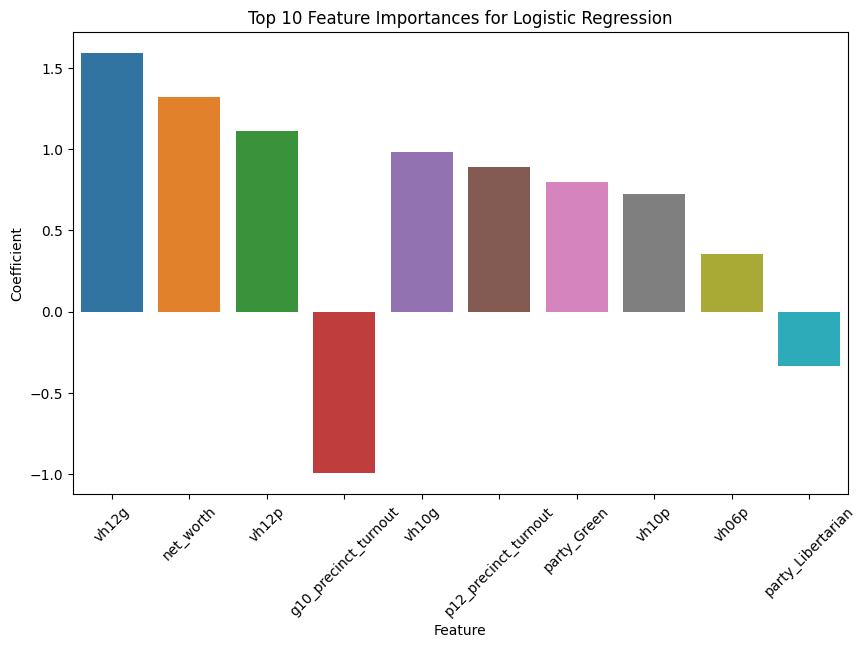

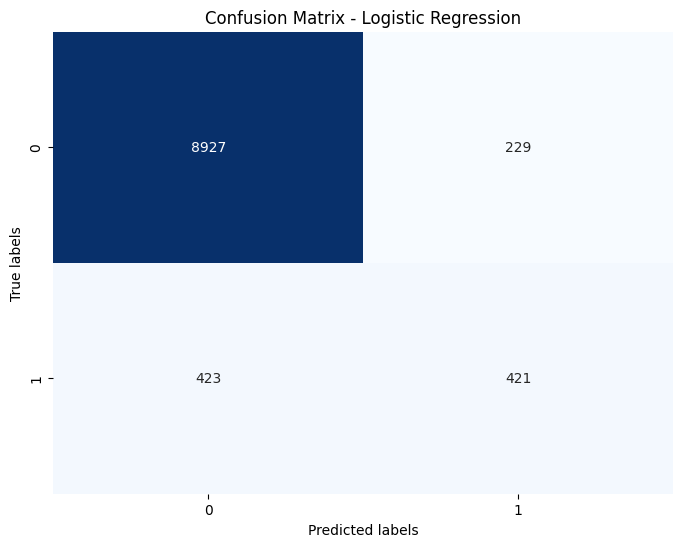

In [48]:
# Get feature importances from logistic regression coefficients
log_reg_coefficients = log_reg_l1.coef_[0]

# Sort features based on their coefficients
sorted_features_log_reg = sorted(zip(X.columns, log_reg_coefficients), key=lambda x: abs(x[1]), reverse=True)

# Visualize feature importances for logistic regression
plt.figure(figsize=(10, 6))
sns.barplot(x=[feat[0] for feat in sorted_features_log_reg[:10]], y=[feat[1] for feat in sorted_features_log_reg[:10]])
plt.title('Top 10 Feature Importances for Logistic Regression')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.show()



# Plot confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
cm_lr = confusion_matrix(y_test, y_pred_selected)
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


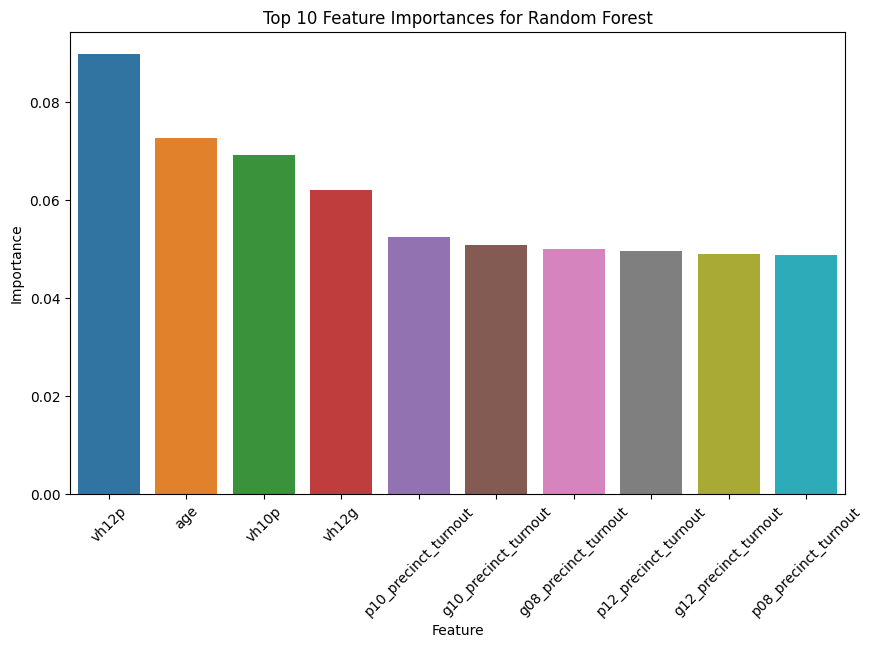

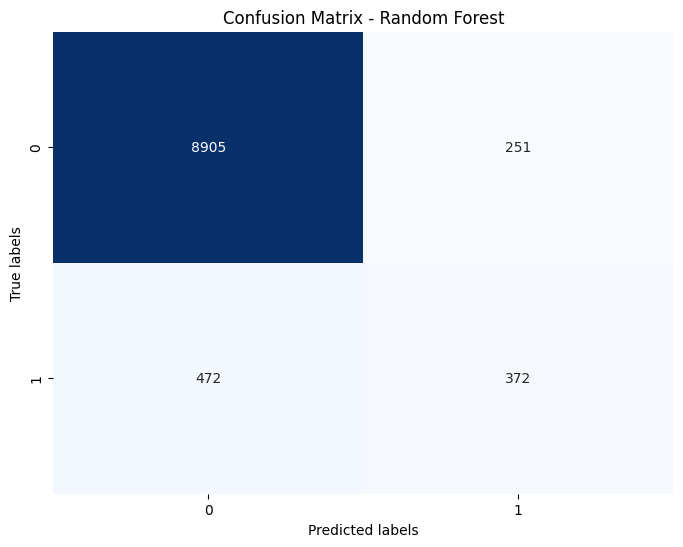

In [49]:
# Visualize feature importances for Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(x=[feat[0] for feat in sorted_features_rf[:10]], y=[feat[1] for feat in sorted_features_rf[:10]])
plt.title('Top 10 Feature Importances for Random Forest')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

# Plot confusion matrix for Random Forest
plt.figure(figsize=(8, 6))
cm_rf = confusion_matrix(y_test, y_pred_selected_rf)
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()


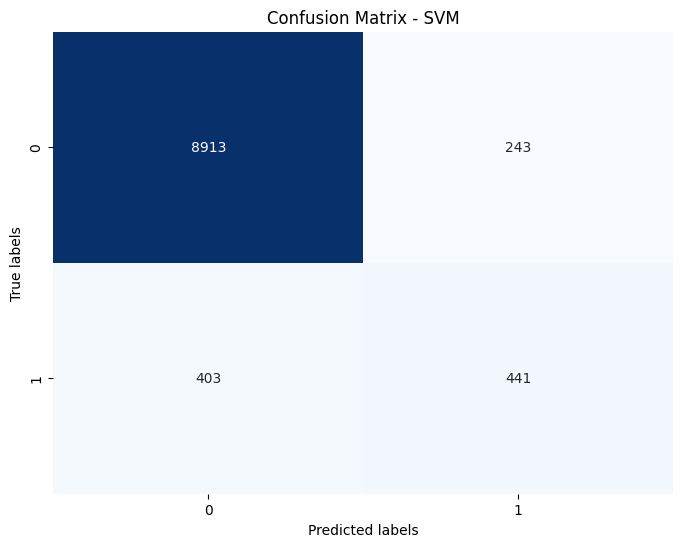

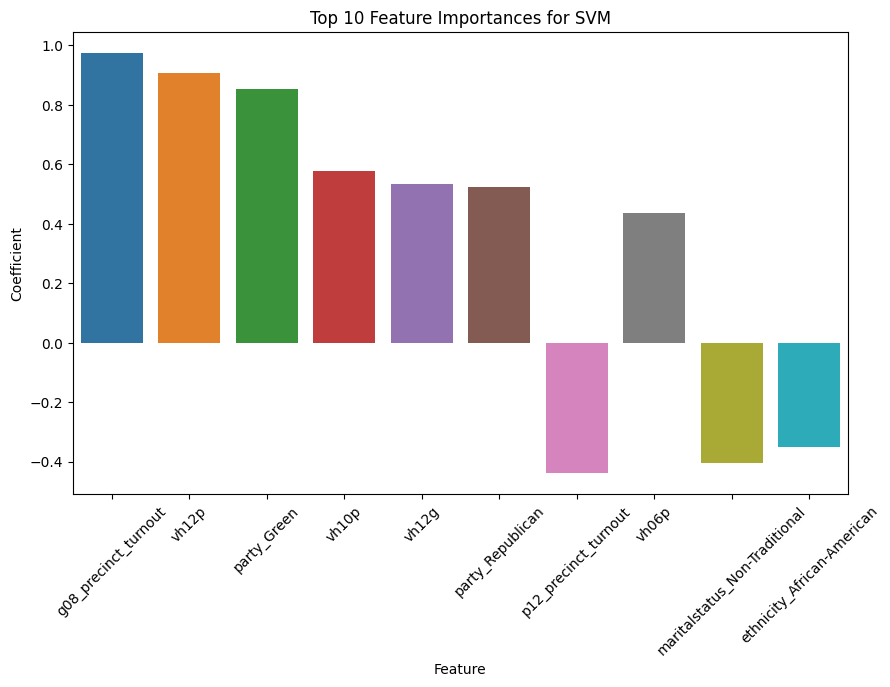

In [50]:
# Plot confusion matrix for SVM
plt.figure(figsize=(8, 6))
cm_svm = confusion_matrix(y_test, y_pred_selected_svm)
sns.heatmap(cm_svm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - SVM')
plt.show()

# Get feature importances from SVM coefficients
svm_coefficients = svm_classifier.coef_[0]

# Sort features based on their coefficients
sorted_features_svm = sorted(zip(X.columns, svm_coefficients), key=lambda x: abs(x[1]), reverse=True)

# Visualize feature importances for SVM
plt.figure(figsize=(10, 6))
sns.barplot(x=[feat[0] for feat in sorted_features_svm[:10]], y=[feat[1] for feat in sorted_features_svm[:10]])
plt.title('Top 10 Feature Importances for SVM')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.show()



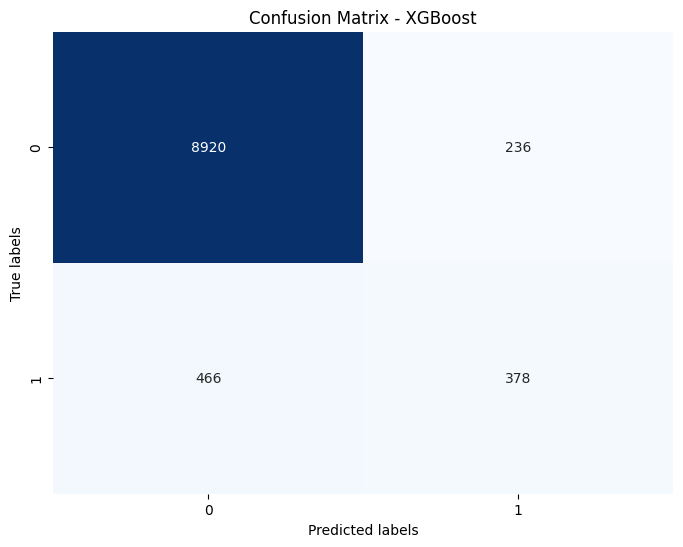

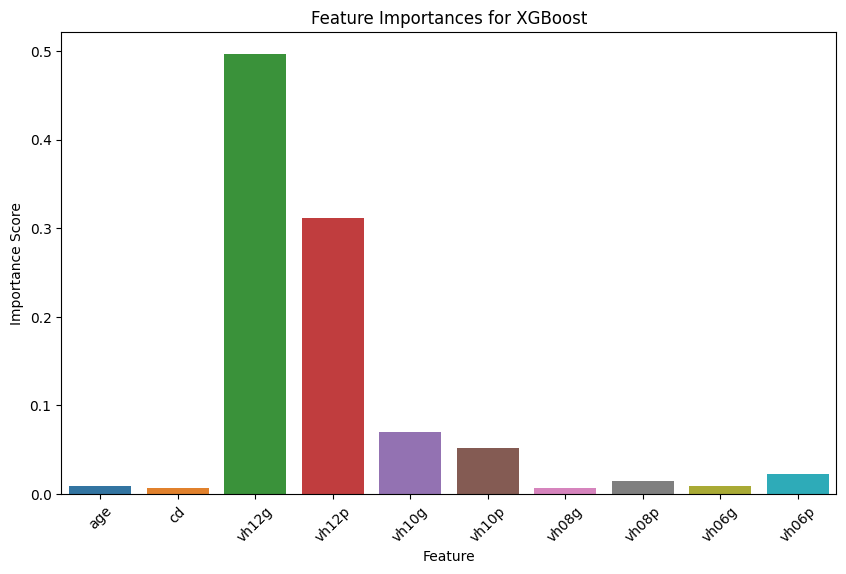

In [51]:
# Plot confusion matrix for XGBoost
plt.figure(figsize=(8, 6))
cm_xgb = confusion_matrix(y_test, y_pred_selected_xgb)
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Visualize feature importances for XGBoost
plt.figure(figsize=(10, 6))
sns.barplot(x=selected_features_xgb, y=xgb_classifier.feature_importances_)
plt.title('Feature Importances for XGBoost')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.show()
